#**S25 - Evidencia de Aprendizaje 1**

##INSTALACIONES Y CONFIGURACIÓN INICIAL

In [ ]:
# Instala las librerías necesarias KaggleHub y ydata-profiling
# --upgrade --quiet asegura que se actualicen y no muestren la salida detallada
!pip install kagglehub[pandas-datasets] ydata-profiling --upgrade --quiet

# Importa la librería pandas para manipulación de datos
import pandas as pd
# Importa kagglehub para cargar datasets de Kaggle
import kagglehub
# Importa KaggleDatasetAdapter para especificar el tipo de adaptador (Pandas en este caso)
from kagglehub import KaggleDatasetAdapter
# Importa ProfileReport de ydata-profiling para generar reportes exploratorios
from ydata_profiling import ProfileReport
# Importa numpy para operaciones numéricas (aunque no se usa directamente en esta celda, es una importación común)
import numpy as np
# Importa display para mostrar DataFrames de forma más amigable en Colab
from IPython.display import display
# Importa warnings para manejar advertencias
import warnings
# Ignora las advertencias para no saturar la salida
warnings.filterwarnings('ignore')

# Configura pandas para mostrar todas las columnas de un DataFrame
pd.set_option('display.max_columns', None)
# Configura pandas para mostrar números flotantes con 2 decimales
pd.set_option('display.precision', 2)

## CARGA Y OPTIMIZACIÓN DE DATOS

In [ ]:
import time

def load_dataset_fast(file_path="2019-Oct.csv", sample_size=500000):
    """Carga dataset de forma ultra-rápida con optimizaciones automáticas y muestreo."""

    # Tipos optimizados - using the most efficient ones
    dtype_dict = {
        'event_type': 'category',
        'product_id': 'int32',
        'category_id': 'int64',
        'category_code': 'category',
        'brand': 'category',
        'price': 'float32',
        'user_id': 'int32',
        'user_session': 'category'
    }

    print(f"Cargando: {file_path}")
    start_time = time.time()

    try:
        # OPTIMIZACIÓN 1: Cargar con tipos desde el inicio
        # kagglehub.load_dataset does not have a dtype parameter, removing it.
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "mkechinov/ecommerce-behavior-data-from-multi-category-store",
            file_path,
            # dtype=dtype_dict # Removed as it's not supported
        )
        print("Cargado con tipos optimizados")

    except:
        # OPTIMIZACIÓN 2: Carga rápida + conversión eficiente
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "mkechinov/ecommerce-behavior-data-from-multi-category-store",
            file_path
        )

        # Conversión rápida por lotes
        print("Optimizando tipos...")

        # Convertir categóricas (más rápido en lote)
        categorical_cols = ['event_type', 'category_code', 'brand', 'user_session']
        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')

        # Convertir numéricos (downcast automático)
        numeric_cols = {'product_id': 'int32', 'user_id': 'int32', 'price': 'float32'}
        for col, dtype in numeric_cols.items():
            if col in df.columns:
                # Removed downcast argument as it was causing the error
                df[col] = pd.to_numeric(df[col], errors='ignore')
                # Convert to specific dtype after to_numeric
                df[col] = df[col].astype(dtype)

    # OPTIMIZACIÓN 3: Muestreo si el dataset es más grande que el sample_size
    if len(df) > sample_size:
        print(f"Dataset grande ({len(df):,} filas), tomando muestra de {sample_size:,}")
        # Muestreo estratificado por 'event_type' si es posible
        if 'event_type' in df.columns and df['event_type'].nunique() > 1:
             df = df.groupby('event_type', group_keys=False).apply(
                lambda x: x.sample(n=min(len(x), sample_size // df['event_type'].nunique()), random_state=42)
            ).reset_index(drop=True)
        else:
            df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        print(f"Dataset pequeño ({len(df):,} filas), usando dataset completo")


    # OPTIMIZACIÓN 4: Stats rápidos
    elapsed = time.time() - start_time
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2

    print(f" Dataset cargado y muestreado en {elapsed:.1f}s:")
    print(f"  • Filas: {len(df):,}")
    print(f"  • Columnas: {len(df.columns)}")
    print(f"  • Memoria: {memory_mb:.1f} MB")

    return df

# Uso ultra-simple con sample_size=500000:
df = load_dataset_fast(sample_size=500000)

Cargando: 2019-Oct.csv
Cargado con tipos optimizados
Dataset grande (42,448,764 filas), tomando muestra de 500,000
 Dataset cargado y muestreado en 180.5s:
  • Filas: 499,998
  • Columnas: 9
  • Memoria: 189.1 MB


## ANÁLISIS EXPLORATORIO BÁSICO

In [ ]:
# Muestra las primeras 5 filas del DataFrame para una vista previa
display(df.head())

# Muestra información sobre el DataFrame, incluyendo tipos de datos, valores no nulos y uso de memoria (calculado profundamente)
df.info(memory_usage='deep')

# Muestra estadísticas descriptivas del DataFrame.
# include='all' asegura que se incluyan estadísticas para columnas numéricas y categóricas.
display(df.describe(include='all'))

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58 UTC,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58 UTC,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37 UTC,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22 UTC,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499998 entries, 0 to 499997
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     499998 non-null  object 
 1   event_type     499998 non-null  object 
 2   product_id     499998 non-null  int64  
 3   category_id    499998 non-null  int64  
 4   category_code  387594 non-null  object 
 5   brand          458817 non-null  object 
 6   price          499998 non-null  float64
 7   user_id        499998 non-null  int64  
 8   user_session   499998 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 189.1 MB


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,499998,499998,5.00e+05,5.00e+05,387594,458817,499998.00,5.00e+05,499998
unique,441485,3,NaN,NaN,124,2188,NaN,NaN,437668
top,2019-10-26 11:45:01 UTC,cart,NaN,NaN,electronics.smartphone,samsung,NaN,NaN,1978995d-aa3c-47c4-94bb-1e1eea9c9457
freq,12,166666,NaN,NaN,218042,112848,NaN,NaN,30
mean,NaN,NaN,6.85e+06,2.06e+18,NaN,NaN,310.30,5.35e+08,NaN
std,NaN,NaN,9.61e+06,1.52e+16,NaN,NaN,353.73,1.84e+07,NaN
min,NaN,NaN,1.00e+06,2.05e+18,NaN,NaN,0.00,2.84e+08,NaN
25%,NaN,NaN,1.00e+06,2.05e+18,NaN,NaN,88.81,5.16e+08,NaN
50%,NaN,NaN,1.80e+06,2.05e+18,NaN,NaN,179.93,5.33e+08,NaN
75%,NaN,NaN,8.80e+06,2.05e+18,NaN,NaN,373.98,5.53e+08,NaN


## ANÁLISIS DE VALORES ÚNICOS Y NULOS

In [ ]:
# Inicializa un diccionario para almacenar el conteo de valores únicos por columna
unique_counts = {}
# Itera sobre cada columna del DataFrame
for col in df.columns:
    # Calcula el número de valores únicos para la columna actual y lo almacena en el diccionario
    unique_counts[col] = df[col].nunique()
    # Imprime el nombre de la columna y el número de valores únicos, formateado con comas
    print(f"   • {col}: {unique_counts[col]:,} valores únicos")

# Calcula el número de valores nulos para cada columna
null_counts = df.isnull().sum()
# Comprueba si hay alguna columna con valores nulos (si la suma de nulos es mayor que 0)
if null_counts.sum() > 0:
    # Si hay nulos, imprime un encabezado
    print("Columnas con valores nulos:")
    # Itera sobre las columnas que tienen valores nulos (donde el conteo es mayor que 0)
    for col, count in null_counts[null_counts > 0].items():
        # Imprime el nombre de la columna, el número de valores nulos y su porcentaje respecto al total de filas
        print(f"• {col}: {count:,} ({count/len(df)*100:.2f}%)")
# Si no hay valores nulos en ninguna columna
else:
    # Imprime un mensaje indicando que no hay valores nulos
    print("No hay valores nulos en el dataset")

   • event_time: 441,485 valores únicos
   • event_type: 3 valores únicos
   • product_id: 45,106 valores únicos
   • category_id: 588 valores únicos
   • category_code: 124 valores únicos
   • brand: 2,188 valores únicos
   • price: 25,316 valores únicos
   • user_id: 317,820 valores únicos
   • user_session: 437,668 valores únicos
Columnas con valores nulos:
• category_code: 112,404 (22.48%)
• brand: 41,181 (8.24%)


## ANÁLISIS ESPECÍFICO E-COMMERCE

In [ ]:
# Calcula la distribución de los tipos de eventos y la imprime
event_dist = df['event_type'].value_counts()
print(event_dist)
# Imprime un encabezado para los porcentajes
print(f"\nPorcentajes:")
# Itera sobre la distribución de eventos y calcula e imprime el porcentaje de cada tipo de evento
for event, count in event_dist.items():
    print(f"   • {event}: {count/len(df)*100:.2f}%")

# Calcula los 10 productos más frecuentes (por conteo) y los imprime
top_products = df['product_id'].value_counts().head(10)
print(top_products)

# Calcula las 10 marcas más frecuentes (por conteo) y las imprime
top_brands = df['brand'].value_counts().head(10)
print(top_brands)

# Calcula estadísticas descriptivas para la columna 'price' y las imprime
price_stats = df['price'].describe()
print(price_stats)

# Itera sobre los valores únicos en la columna 'event_type'
for event_type in df['event_type'].unique():
    # Filtra el DataFrame para obtener solo las filas del tipo de evento actual
    event_prices = df[df['event_type'] == event_type]['price']
    # Imprime el tipo de evento
    print(f"\n{event_type}:")
    # Calcula e imprime el precio promedio para este tipo de evento
    print(f"• Promedio: ${event_prices.mean():.2f}")
    # Calcula e imprime la mediana del precio para este tipo de evento
    print(f"• Mediana: ${event_prices.median():.2f}")
    # Calcula e imprime el precio máximo para este tipo de evento
    print(f"• Máximo: ${event_prices.max():.2f}")

event_type
cart        166666
purchase    166666
view        166666
Name: count, dtype: int64

Porcentajes:
   • cart: 33.33%
   • purchase: 33.33%
   • view: 33.33%
product_id
1004856    17600
1004767    13034
1004833     7611
4804056     7565
1005115     6855
1004870     6610
1002544     5945
5100816     5634
1004249     5482
1004836     4844
Name: count, dtype: int64
brand
samsung    112848
apple       84834
xiaomi      43403
huawei      17142
oppo         8087
lg           6758
lucente      5290
sony         5042
acer         4963
bosch        4750
Name: count, dtype: int64
count    499998.00
mean        310.30
std         353.73
min           0.00
25%          88.81
50%         179.93
75%         373.98
max        2574.07
Name: price, dtype: float64

cart:
• Promedio: $333.69
• Mediana: $196.94
• Máximo: $2574.04

purchase:
• Promedio: $308.55
• Mediana: $179.28
• Máximo: $2574.04

view:
• Promedio: $288.66
• Mediana: $161.14
• Máximo: $2574.07


## PREPARACIÓN DE MUESTRA PARA REPORTE

In [ ]:
# Obtiene el número total de filas en el DataFrame
total_rows = len(df)
# Define un tamaño de muestra si el dataset es grande
if total_rows > 100000:
    sample_size = 50000 # Tamaño de muestra para datasets muy grandes
    print(f"Dataset grande ({total_rows:,} filas), usando muestra de {sample_size:,}")
# Define un tamaño de muestra si el dataset es mediano
elif total_rows > 50000:
    sample_size = 25000 # Tamaño de muestra para datasets medianos
    print(f"Dataset mediano ({total_rows:,} filas), usando muestra de {sample_size:,}")
# Si el dataset es pequeño, usa el dataset completo como muestra
else:
    sample_size = total_rows # Usa el total de filas si es pequeño
    print(f"Dataset pequeño ({total_rows:,} filas), usando dataset completo")

# Si el tamaño de la muestra es menor que el total de filas (es decir, si se necesita muestreo)
if sample_size < total_rows:
    # Crea una muestra estratificada por tipo de evento.
    # Agrupa el DataFrame por 'event_type'.
    # Aplica una función lambda a cada grupo para tomar una muestra.
    # El tamaño de la muestra para cada grupo es el mínimo entre el tamaño del grupo y el tamaño total de la muestra dividido por el número de tipos de eventos únicos.
    # random_state=42 asegura reproducibilidad.
    # reset_index(drop=True) reinicia el índice y elimina la columna de índice original.
    df_muestra = df.groupby('event_type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size//len(df['event_type'].unique())),
                          random_state=42)
    ).reset_index(drop=True)
# Si no se necesita muestreo (dataset pequeño), la muestra es una copia del DataFrame original
else:
    df_muestra = df.copy()

Dataset grande (499,998 filas), usando muestra de 50,000


## GENERACIÓN DE REPORTE YDATA-PROFILING

In [ ]:
# Define un diccionario de configuración para el reporte de ydata-profiling.
# 'minimal': True genera un reporte más rápido y básico.
# 'interactions': {'continuous': False} desactiva el análisis de interacciones entre variables continuas.
# 'correlations': {'auto': {'calculate': False}} desactiva el cálculo de correlaciones.
# 'missing_diagrams': desactiva los diagramas de valores faltantes.
# 'duplicates': {'head': 0} desactiva la visualización de filas duplicadas.
# 'samples': {'head': 5, 'tail': 5} muestra las primeras y últimas 5 filas como ejemplo.
config = {
    'minimal': True,
    'interactions': {'continuous': False},
    'correlations': {'auto': {'calculate': False}},
    'missing_diagrams': {'bar': False, 'matrix': False, 'heatmap': False},
    'duplicates': {'head': 0},
    'samples': {'head': 5, 'tail': 5}
}

# Crea una instancia de ProfileReport utilizando el DataFrame de muestra y la configuración definida.
reporte = ProfileReport(
    df_muestra, # DataFrame a analizar
    title="E-commerce Behavior Data Analysis", # Título del reporte
    config_file=None, # No usa un archivo de configuración externo
    **config # Desempaqueta el diccionario de configuración como argumentos
)

# Define el nombre del archivo de salida para el reporte HTML
output_file = 'reporte_ecommerce_segmentado.html'
# Imprime un mensaje indicando dónde se guardará el reporte
print(f"Guardando reporte como: {output_file}")
# Guarda el reporte en un archivo HTML
reporte.to_file(output_file)

Guardando reporte como: reporte_ecommerce_segmentado.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## RESUMEN FINAL Y CONCLUSIONES

In [ ]:
# Imprime un resumen del dataset, incluyendo el número total de filas y columnas
print(f"Dataset: {total_rows:,} filas × {df.shape[1]} columnas")
# Imprime el rango de fechas cubierto por el dataset (desde el evento más antiguo hasta el más reciente)
print(f"Período: {df['event_time'].min()} a {df['event_time'].max()}")
# Imprime el número de usuarios únicos en el dataset
print(f"Usuarios únicos: {df['user_id'].nunique():,}")
# Imprime el número de productos únicos en el dataset
print(f"Productos únicos: {df['product_id'].nunique():,}")
# Imprime el número de marcas únicas en el dataset
print(f"Marcas únicas: {df['brand'].nunique():,}")
# Imprime el número de sesiones únicas en el dataset
print(f"Sesiones únicas: {df['user_session'].nunique():,}")

# Imprime un encabezado para el conteo de eventos por tipo
print(f"\nEventos por tipo:")
# Itera sobre la distribución de los tipos de eventos y los imprime con su conteo y porcentaje
for event, count in df['event_type'].value_counts().items():
    print(f"   • {event}: {count:,} ({count/len(df)*100:.1f}%)")

# Imprime el valor promedio de los productos (basado en la columna 'price')
print(f"\nValor promedio de productos: ${df['price'].mean():.2f}")
# Imprime el rango de precios (mínimo y máximo)
print(f"Rango de precios: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

# Imprime la ruta donde se guardó el reporte detallado
print(f"Reporte detallado disponible en: {output_file}")

Dataset: 499,998 filas × 9 columnas
Período: 2019-10-01 00:01:07 UTC a 2019-10-31 23:59:21 UTC
Usuarios únicos: 317,820
Productos únicos: 45,106
Marcas únicas: 2,188
Sesiones únicas: 437,668

Eventos por tipo:
   • cart: 166,666 (33.3%)
   • purchase: 166,666 (33.3%)
   • view: 166,666 (33.3%)

Valor promedio de productos: $310.30
Rango de precios: $0.00 - $2574.07
Reporte detallado disponible en: reporte_ecommerce_segmentado.html


## FUNCIONES ADICIONAL PARA ANÁLISIS

In [ ]:
# Define una función para analizar la actividad de un usuario específico
def analizar_usuario_especifico(user_id):
    # Filtra el DataFrame para obtener solo los datos del usuario especificado
    user_data = df[df['user_id'] == user_id]
    # Si no se encuentra el usuario (el DataFrame filtrado está vacío)
    if len(user_data) == 0:
        # Imprime un mensaje indicando que el usuario no fue encontrado
        print(f"Usuario {user_id} no encontrado")
        # Sale de la función
        return

    # Imprime un encabezado para el análisis del usuario
    print(f"\n--- ANÁLISIS USUARIO {user_id} ---")
    # Imprime el número total de eventos registrados para este usuario
    print(f"Total de eventos: {len(user_data)}")
    # Imprime un encabezado para los eventos por tipo
    print(f"Eventos por tipo:")
    # Imprime el conteo de cada tipo de evento para este usuario
    print(user_data['event_type'].value_counts())
    # Imprime el número de productos únicos que el usuario vio
    print(f"Productos únicos vistos: {user_data['product_id'].nunique()}")
    # Calcula e imprime el gasto total estimado del usuario (suma de precios de eventos de compra, aunque no se especifica el tipo de evento aquí, se asume un análisis general)
    print(f"Gasto total: ${user_data['price'].sum():.2f}")
    # Imprime un encabezado para las marcas favoritas
    print(f"Marcas favoritas:")
    # Imprime las 5 marcas más frecuentes interactuadas por el usuario
    print(user_data['brand'].value_counts().head(5))

# Define una función para analizar la actividad relacionada con un producto específico
def analizar_producto_especifico(product_id):
    # Filtra el DataFrame para obtener solo los datos relacionados con el producto especificado
    product_data = df[df['product_id'] == product_id]
    # Si no se encuentra el producto (el DataFrame filtrado está vacío)
    if len(product_data) == 0:
        # Imprime un mensaje indicando que el producto no fue encontrado
        print(f"Producto {product_id} no encontrado")
        # Sale de la función
        return

    # Imprime un encabezado para el análisis del producto
    print(f"\n--- ANÁLISIS PRODUCTO {product_id} ---")
    # Imprime el número total de interacciones registradas para este producto
    print(f"Total de interacciones: {len(product_data)}")
    # Imprime el número de usuarios únicos que interactuaron con este producto
    print(f"Usuarios únicos: {product_data['user_id'].nunique()}")
    # Imprime el precio del producto (toma el precio de la primera fila encontrada)
    print(f"Precio: ${product_data['price'].iloc[0]:.2f}")
    # Imprime la marca del producto (toma la marca de la primera fila encontrada)
    print(f"Marca: {product_data['brand'].iloc[0]}")
    # Imprime la categoría del producto (toma la categoría de la primera fila encontrada)
    print(f"Categoría: {product_data['category_code'].iloc[0]}")
    # Imprime un encabezado para los eventos por tipo relacionados con el producto
    print(f"Eventos por tipo:")
    # Imprime el conteo de cada tipo de evento para este producto
    print(product_data['event_type'].value_counts())

# **S20 - Evidencia de aprendizaje 2**

## ELIMINACIÓN DE DUPLICADOS


In [ ]:
# Almacena el número inicial de filas en el DataFrame
initial_rows = len(df)
# Elimina las filas duplicadas del DataFrame in-place (modifica el DataFrame directamente)
df.drop_duplicates(inplace=True)
# Almacena el número final de filas después de eliminar duplicados
final_rows = len(df)
# Calcula el número de duplicados que fueron eliminados
duplicates_removed = initial_rows - final_rows

# Imprime el número inicial de filas
print(f"Filas iniciales: {initial_rows:,}")
# Imprime el número final de filas
print(f"Filas finales: {final_rows:,}")
# Imprime el número de duplicados eliminados
print(f"Duplicados eliminados: {duplicates_removed:,}")
# Imprime un mensaje indicando si se eliminaron duplicados o no
print(f"¡Dataset limpio!" if duplicates_removed > 0 else "No había duplicados.")

Filas iniciales: 499,998
Filas finales: 498,386
Duplicados eliminados: 1,612
¡Dataset limpio!


## TRATAMIENTO DE VALORES NULOS

In [ ]:
# Calcula el número de valores nulos por columna antes del tratamiento
null_counts_before = df.isnull().sum()
# Obtiene una lista de los nombres de las columnas que tienen valores nulos
cols_with_nulls = null_counts_before[null_counts_before > 0].index.tolist()

# Verifica si hay columnas con valores nulos
if cols_with_nulls:
    # Imprime un encabezado indicando las columnas con nulos antes del tratamiento
    print("Columnas con valores nulos antes del tratamiento:")
    # Itera sobre las columnas con nulos
    for col in cols_with_nulls:
        # Obtiene el conteo de nulos para la columna actual
        count = null_counts_before[col]
        # Imprime el nombre de la columna, el conteo de nulos y su porcentaje
        print(f"• {col}: {count:,} ({count/len(df)*100:.2f}%)")

    # Itera nuevamente sobre las columnas que tenían nulos para aplicar el tratamiento
    for col in cols_with_nulls:
        # Verifica si la columna actual todavía tiene valores nulos (importante si el tratamiento anterior no fue para todas las columnas)
        if df[col].isnull().sum() > 0:
            # Si la columna es 'user_session'
            if col == 'user_session':
                # Almacena el número de filas antes de eliminar nulos en 'user_session'
                initial_rows_session = len(df)
                # Elimina las filas donde 'user_session' es nulo in-place
                df.dropna(subset=[col], inplace=True)
                # Almacena el número de filas después de eliminar nulos en 'user_session'
                rows_after_dropping_session = len(df)
                # Calcula el número de filas eliminadas debido a nulos en 'user_session'
                dropped_session_rows = initial_rows_session - rows_after_dropping_session
                # Imprime cuántas filas fueron eliminadas por nulos en 'user_session'
                print(f"Filas con valores nulos en '{col}' eliminadas: {dropped_session_rows}")
            # Si la columna no es 'user_session'
            else:
                # Calcula la moda (valor más frecuente) de la columna
                mode_value = df[col].mode()[0]
                # Rellena los valores nulos en la columna con la moda in-place
                df[col].fillna(mode_value, inplace=True)
                # Imprime un mensaje indicando que se imputaron los nulos con la moda
                print(f"Valores nulos en '{col}' imputados con la moda: '{mode_value}'")

# Si no había columnas con valores nulos inicialmente
else:
    # Imprime un mensaje indicando que no hay valores nulos
    print("No hay valores nulos en el dataset")

# Calcula el número de valores nulos por columna después del tratamiento
null_counts_after = df.isnull().sum()
# Verifica si no quedan valores nulos (si la suma de nulos es 0)
if null_counts_after.sum() == 0:
    # Imprime un mensaje indicando que todos los nulos fueron tratados
    print("\n¡Todos los valores nulos han sido tratados!")
# Si todavía hay columnas con valores nulos
else:
    # Imprime un encabezado indicando las columnas restantes con nulos
    print("\nColumnas con valores nulos restantes:")
    # Itera sobre las columnas que todavía tienen nulos y las imprime con su conteo
    for col, count in null_counts_after[null_counts_after > 0].items():
        print(f"• {col}: {count:,}")

# Muestra las primeras filas del DataFrame después del tratamiento de nulos
display(df.head())

Columnas con valores nulos antes del tratamiento:
• category_code: 112,247 (22.52%)
• brand: 41,132 (8.25%)
Valores nulos en 'category_code' imputados con la moda: 'electronics.smartphone'
Valores nulos en 'brand' imputados con la moda: 'samsung'

¡Todos los valores nulos han sido tratados!


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58 UTC,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58 UTC,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37 UTC,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22 UTC,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


## CONVERSIÓN DE TIPOS DE DATOS

In [ ]:
# Convierte la columna 'event_time' al tipo de dato datetime de pandas.
# Esto permite realizar operaciones basadas en tiempo.
df['event_time'] = pd.to_datetime(df['event_time'])
# Imprime un mensaje indicando que la conversión se realizó
print("Convertido 'event_time' a objetos de datetime.")

# Define una lista de nombres de columnas que deberían ser de tipo categórico
categorical_cols = ['event_type', 'category_code', 'brand', 'user_session']
# Itera sobre la lista de columnas categóricas potenciales
for col in categorical_cols:
    # Verifica si la columna existe en el DataFrame y si su tipo de dato actual no es 'category'
    if col in df.columns and df[col].dtype != 'category':
        # Convierte la columna al tipo de dato 'category'
        df[col] = df[col].astype('category')
        # Imprime un mensaje indicando que la columna fue convertida
        print(f"Convertido '{col}' al tipo de dato categoría.")

# Imprime un encabezado para mostrar los tipos de datos después del ajuste
print("\nTipos de datos después del ajuste:")
# Muestra información sobre el DataFrame, incluyendo los tipos de datos actualizados y el uso de memoria (calculado profundamente)
df.info(memory_usage='deep')

Convertido 'event_time' a objetos de datetime.
Convertido 'event_type' al tipo de dato categoría.
Convertido 'category_code' al tipo de dato categoría.
Convertido 'brand' al tipo de dato categoría.
Convertido 'user_session' al tipo de dato categoría.

Tipos de datos después del ajuste:
<class 'pandas.core.frame.DataFrame'>
Index: 498386 entries, 0 to 499997
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     498386 non-null  datetime64[ns, UTC]
 1   event_type     498386 non-null  category           
 2   product_id     498386 non-null  int64              
 3   category_id    498386 non-null  int64              
 4   category_code  498386 non-null  category           
 5   brand          498386 non-null  category           
 6   price          498386 non-null  float64            
 7   user_id        498386 non-null  int64              
 8   user_session   498386 non-null  c

## IDENTIFICACIÓN DE COLUMNAS NUMÉRICAS Y ANÁLISIS DE OUTLIERS

In [ ]:
# Inicializa una lista vacía para almacenar los nombres de las columnas numéricas
numerical_cols = []
# Itera sobre todas las columnas del DataFrame
for col in df.columns:
    # Verifica si el tipo de dato de la columna actual es uno de los tipos numéricos especificados
    if df[col].dtype in ['int66', 'int32', 'float64', 'float32']:
        # Si es un tipo numérico, agrega el nombre de la columna a la lista
        numerical_cols.append(col)

# Imprime un encabezado indicando las columnas numéricas identificadas
print("Columnas numéricas identificadas:")
# Imprime la lista de columnas numéricas
print(numerical_cols)

Columnas numéricas identificadas:
['price']


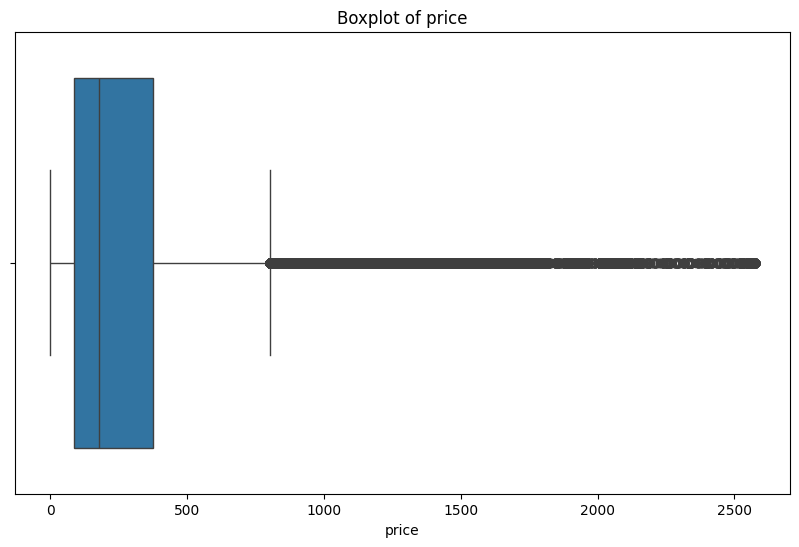

In [ ]:
# Importa las librerías necesarias para graficar: matplotlib.pyplot y seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Itera sobre la lista de columnas numéricas identificadas previamente
for col in numerical_cols:
    # Crea una nueva figura para cada boxplot con un tamaño específico
    plt.figure(figsize=(10, 6))
    # Crea un boxplot para la columna numérica actual utilizando seaborn
    sns.boxplot(x=df[col])
    # Establece el título del gráfico usando el nombre de la columna
    plt.title(f'Boxplot of {col}')
    # Muestra el gráfico
    plt.show()

## TRATAMIENTO DE VALORES ATÍPICOS (OUTLIERS)

In [ ]:
# Instala la librería feature-engine.
# --quiet suprime la salida detallada de la instalación.
!pip install feature-engine --quiet

In [ ]:
# Importa la clase Winsorizer de feature_engine.outliers
from feature_engine.outliers import Winsorizer

# Crea una instancia de Winsorizer.
# capping_method='gaussian' utiliza la media y la desviación estándar para determinar los límites.
# tail='right' aplica la winsorización solo al extremo superior (valores atípicos altos).
# fold=1.5 define el factor multiplicador de la desviación estándar para calcular el límite (Media + 1.5 * Desviación Estándar).
# variables=['price'] especifica que la winsorización se aplicará solo a la columna 'price'.
winsorizer = Winsorizer(capping_method='gaussian', tail='right', fold=1.5, variables=['price'])

# Aplica la winsorización a la columna 'price' del DataFrame.
# fit_transform calcula los límites y aplica la transformación en un solo paso.
# Se pasa df[['price']] para asegurarse de que se aplica a un DataFrame (Winsorizer espera un DataFrame).
df['price'] = winsorizer.fit_transform(df[['price']])

# Imprime un mensaje indicando que se realizó la winsorización en la columna 'price'
print("Se trataron los valores atípicos en la columna 'price' utilizando Winsorización (el extremo derecho se limita a 1.5 desviaciones estándar de la media).")
# Muestra las primeras filas del DataFrame después de la winsorización para verificar los cambios
display(df.head())

Se trataron los valores atípicos en la columna 'price' utilizando Winsorización (el extremo derecho se limita a 1.5 desviaciones estándar de la media).


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58+00:00,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32+00:00,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58+00:00,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37+00:00,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22+00:00,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


## CORRECCIÓN DE ERRORES TIPOGRÁFICOS

###Identificación de errores

In [ ]:
# Define una lista con los nombres de las columnas que podrían contener errores tipográficos (basado en análisis previo)
potential_error_cols = ['category_code', 'brand']
# Imprime un encabezado indicando las columnas a verificar para errores tipográficos
print("Posibles columnas para la corrección de errores tipográficos:")
# Itera sobre la lista de columnas potenciales y las imprime
for col in potential_error_cols:
    print(f"- {col}")

Posibles columnas para la corrección de errores tipográficos:
- category_code
- brand


In [ ]:
# Imprime un encabezado indicando que se examinarán los valores únicos en 'category_code'
print("Examinando los valores únicos en 'category_code' para posibles errores:")
# Muestra los 50 valores únicos más frecuentes y sus conteos en la columna 'category_code'
display(df['category_code'].value_counts().head(50))

# Imprime un encabezado indicando que se examinarán los valores únicos en 'brand'
print("\nExaminando los valores únicos en 'brand' en busca de errores potenciales:")
# Muestra los 50 valores únicos más frecuentes y sus conteos en la columna 'brand'
display(df['brand'].value_counts().head(50))

Examinando los valores únicos en 'category_code' para posibles errores:


,count
category_code,
electronics.smartphone,329236
electronics.audio.headphone,20162
electronics.video.tv,15553
electronics.clocks,12654
computers.notebook,11037
appliances.kitchen.washer,10986
appliances.environment.vacuum,9060
appliances.kitchen.refrigerators,8268
apparel.shoes,4128



Examinando los valores únicos en 'brand' en busca de errores potenciales:


,count
brand,
samsung,153328
apple,84532
xiaomi,43259
huawei,17051
oppo,8046
lg,6727
lucente,5290
sony,5030
acer,4953


### Aplicación de correcciones

In [ ]:
# Define un diccionario para mapear valores incorrectos a valores correctos en 'category_code'
category_code_replacements = {
    'electronics.smartphone ': 'electronics.smartphone', # Corrige espacio al final
    'electronics.telephone': 'electronics.smartphone',   # Mapea 'telephone' a 'smartphone'
}

# Define un diccionario para mapear valores incorrectos a valores correctos en 'brand'
brand_replacements = {
    'samsung ': 'samsung', # Corrige espacio al final
    'apple ': 'apple',     # Corrige espacio al final
    'xiaomi ': 'xiaomi',   # Corrige espacio al final
}

# Aplica los reemplazos a la columna 'category_code' utilizando el método replace()
df['category_code'] = df['category_code'].replace(category_code_replacements)
# Aplica los reemplazos a la columna 'brand' utilizando el método replace()
df['brand'] = df['brand'].replace(brand_replacements)

# Imprime un mensaje indicando que se aplicaron los reemplazos
print("Se aplicaron reemplazos a las columnas 'category_code' y 'brand'.")
# Muestra las primeras filas del DataFrame después de los reemplazos
display(df.head())

Se aplicaron reemplazos a las columnas 'category_code' y 'brand'.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58+00:00,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32+00:00,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58+00:00,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37+00:00,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22+00:00,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


In [ ]:
# Aplica los reemplazos a las categorías de la columna categórica 'category_code'.
# rename_categories es más eficiente para columnas de tipo 'category'.
# Se usa el diccionario category_code_replacements definido anteriormente.
df['category_code'] = df['category_code'].cat.rename_categories(category_code_replacements)
# Aplica los reemplazos a las categorías de la columna categórica 'brand'.
# Se usa el diccionario brand_replacements definido anteriormente.
df['brand'] = df['brand'].cat.rename_categories(brand_replacements)

# Imprime un mensaje indicando que se aplicaron los reemplazos usando rename_categories
print("Se aplicaron reemplazos a las columnas 'category_code' y 'brand' utilizando rename_categories.")
# Muestra las primeras filas del DataFrame después de los reemplazos
display(df.head())

Se aplicaron reemplazos a las columnas 'category_code' y 'brand' utilizando rename_categories.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58+00:00,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32+00:00,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58+00:00,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37+00:00,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22+00:00,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


In [ ]:
# Define un diccionario de mapeo para category_code.
# Este mapeo consolidará 'electronics.telephone' en 'electronics.smartphone'.
category_code_mapping = {
    'electronics.telephone': 'electronics.smartphone'
}

# Define un diccionario de mapeo para brand.
# Este mapeo consolidará valores con espacios al final.
brand_mapping = {
    'samsung ': 'samsung',
    'apple ': 'apple',
    'xiaomi ': 'xiaomi'
}

# Aplica el mapeo a las categorías de la columna 'category_code' usando rename_categories.
# Esto renombra las categorías según el diccionario de mapeo.
df['category_code'] = df['category_code'].cat.rename_categories(category_code_mapping)
# Imprime un mensaje indicando que se aplicó el mapeo a 'category_code'
print("Aplicó el método map() a la columna 'category_code'.")

# Aplica el mapeo a las categorías de la columna 'brand' usando rename_categories.
# Esto renombra las categorías según el diccionario de mapeo.
df['brand'] = df['brand'].cat.rename_categories(brand_mapping)
# Imprime un mensaje indicando que se aplicó el mapeo a 'brand'
print("Se aplicó el map() a la columna 'brand'.")

# Muestra las primeras filas del DataFrame después de aplicar los mapeos
display(df.head())

Aplicó el método map() a la columna 'category_code'.
Se aplicó el map() a la columna 'brand'.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-04 09:55:58+00:00,cart,1004741,2053013555631882655,electronics.smartphone,xiaomi,185.67,512856885,85a2394c-be15-4bc3-9027-0d486762e470
1,2019-10-26 11:17:32+00:00,cart,5100562,2053013553341792533,electronics.clocks,apple,301.36,513130812,5dbde477-b293-4ab0-aeea-d721791aa0bf
2,2019-10-29 09:14:58+00:00,cart,1004863,2053013555631882655,electronics.smartphone,samsung,170.15,565340594,5b9591ab-2f6d-4aaf-bbe1-85de83ac641f
3,2019-10-24 05:00:37+00:00,cart,1005100,2053013555631882655,electronics.smartphone,samsung,141.32,512750861,9f5ca722-82d8-46dd-8f45-24316aff2c82
4,2019-10-17 08:46:22+00:00,cart,1004858,2053013555631882655,electronics.smartphone,samsung,131.62,561136578,d0ebb3eb-6323-4138-b812-38567d4a36c7


### Verificación de correcciones

In [ ]:
# Imprime un encabezado para verificar las correcciones en 'category_code'
print("Verificando correcciones en 'category_code':")
# Muestra los 10 valores únicos más frecuentes en 'category_code' después de las correcciones
display(df['category_code'].value_counts().head(10))

# Imprime un encabezado para verificar las correcciones en 'brand'
print("\nVerificando correcciones en 'brand':")
# Muestra los 10 valores únicos más frecuentes en 'brand' después de las correcciones
display(df['brand'].value_counts().head(10))

Verificando correcciones en 'category_code':


,count
category_code,
electronics.smartphone,332056
electronics.audio.headphone,20162
electronics.video.tv,15553
electronics.clocks,12654
computers.notebook,11037
appliances.kitchen.washer,10986
appliances.environment.vacuum,9060
appliances.kitchen.refrigerators,8268
apparel.shoes,4128



Verificando correcciones en 'brand':


,count
brand,
samsung,153328
apple,84532
xiaomi,43259
huawei,17051
oppo,8046
lg,6727
lucente,5290
sony,5030
acer,4953


In [ ]:
# Cuenta el número de filas donde 'category_code' es 'electronics.smartphone'.
# Esto incluye tanto los valores originales como los corregidos/mapeados a este valor.
category_code_corrected_count = df[df['category_code'] == 'electronics.smartphone'].shape[0]
# Cuenta el número de filas donde 'brand' es 'samsung'.
brand_corrected_count_samsung = df[df['brand'] == 'samsung'].shape[0]
# Cuenta el número de filas donde 'brand' es 'apple'.
brand_corrected_count_apple = df[df['brand'] == 'apple'].shape[0]
# Cuenta el número de filas donde 'brand' es 'xiaomi'.
brand_corrected_count_xiaomi = df[df['brand'] == 'xiaomi'].shape[0]

# Imprime el conteo de filas con el valor 'electronics.smartphone' después de las correcciones.
# Se aclara que incluye filas que ya tenían este valor.
print(f"Valores corregidos (conteo inferido de filas con valor 'from' mapeado): {category_code_corrected_count:,} filas afectadas (incluye filas que ya eran 'electronics.smartphone')")

# Imprime un encabezado para la columna 'brand'
print("\nColumna: brand")

# Imprime un encabezado para los conteos corregidos de marcas
print(f"\nValores corregidos (conteo inferido de filas con valores 'from' mapeados):\n")

# Imprime el conteo de filas para cada marca después de las correcciones, aclarando que incluye valores originales.
print(f"  - 'samsung' -> 'samsung': {brand_corrected_count_samsung:,} filas afectadas (incluye filas que ya estaban 'samsung')")
print(f"  - 'apple' -> 'apple': {brand_corrected_count_apple:,} filas afectadas (incluye filas que ya estaban'apple')")
print(f"  - 'xiaomi' -> 'xiaomi': {brand_corrected_count_xiaomi:,} filas afectadas (incluye filas que ya estaban 'xiaomi')")
# Imprime un resumen de los mapeos realizados en la columna 'brand'.
print("\nValores mapeados: 'samsung ' -> 'samsung', 'apple ' -> 'apple', 'xiaomi ' -> 'xiaomi'")

Valores corregidos (conteo inferido de filas con valor 'from' mapeado): 332,056 filas afectadas (incluye filas que ya eran 'electronics.smartphone')

Columna: brand

Valores corregidos (conteo inferido de filas con valores 'from' mapeados):

  - 'samsung' -> 'samsung': 153,328 filas afectadas (incluye filas que ya estaban 'samsung')
  - 'apple' -> 'apple': 84,532 filas afectadas (incluye filas que ya estaban'apple')
  - 'xiaomi' -> 'xiaomi': 43,259 filas afectadas (incluye filas que ya estaban 'xiaomi')

Valores mapeados: 'samsung ' -> 'samsung', 'apple ' -> 'apple', 'xiaomi ' -> 'xiaomi'


## ANÁLISIS EXPLORATORIO Y AGREGACIONES

### Conteo de eventos por usuario

In [ ]:
# Agrupa el DataFrame por 'user_id' y 'event_type'.
# Calcula el tamaño de cada grupo (conteo de eventos).
# Usa unstack() para pivotar 'event_type' a columnas, con los conteos como valores.
# fill_value=0 reemplaza los valores NaN (donde un usuario no tiene un tipo de evento particular) con 0.
user_event_counts = df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)
# Imprime un encabezado indicando el contenido del DataFrame resultante
print("Conteo de eventos por usuario y tipo de evento:")
# Muestra las primeras filas del DataFrame con el conteo de eventos por usuario y tipo
display(user_event_counts.head())

Conteo de eventos por usuario y tipo de evento:


event_type,cart,purchase,view
user_id,,,
284344819,1,0,0
293335683,0,0,1
304325717,1,0,0
305836302,0,0,1
326200658,0,0,1


### Análisis de ventas mensuales por categoría

In [ ]:
# Crea una nueva columna 'month' extrayendo el período (Mes) de la columna 'event_time'.
# to_period('M') convierte la fecha a un objeto Period representando el mes.
df['month'] = df['event_time'].dt.to_period('M')

# Filtra el DataFrame para incluir solo eventos de tipo 'purchase'.
# Agrupa los resultados por 'month' y 'category_code'.
# Suma los precios para obtener las ventas totales por mes y categoría.
# observed=True es útil con tipos categóricos para excluir combinaciones no observadas.
# reset_index() convierte el resultado de la agrupación en un DataFrame regular.
monthly_category_sales = df[df['event_type'] == 'purchase'].groupby(['month', 'category_code'], observed=True)['price'].sum().reset_index()
# Imprime un encabezado indicando el contenido del DataFrame resultante
print("Ventas totales por mes y categoría:")
# Muestra las primeras filas del DataFrame con las ventas mensuales por categoría
display(monthly_category_sales.head())

Ventas totales por mes y categoría:


,month,category_code,price
0,2019-10,accessories.bag,11125.55
1,2019-10,accessories.umbrella,152.88
2,2019-10,accessories.wallet,2808.78
3,2019-10,apparel.belt,452.75
4,2019-10,apparel.costume,11457.63


## EVALUACIÓN FINAL DE LA CALIDAD DE DATOS

In [ ]:
# Imprime un encabezado para la evaluación de la completitud de los datos
print("Evaluación de la Completitud de los Datos\n")
# Calcula el número de valores nulos por columna después de todas las limpiezas
null_counts_final = df.isnull().sum()
# Obtiene una lista de nombres de columnas que aún tienen valores nulos
cols_with_nulls_final = null_counts_final[null_counts_final > 0].index.tolist()

# Verifica si hay columnas con valores nulos restantes
if cols_with_nulls_final:
    # Imprime un encabezado para las columnas con nulos restantes
    print("Columnas con valores nulos restantes después del tratamiento:\n")
    # Itera sobre las columnas con nulos restantes y las imprime con su conteo y porcentaje
    for col in cols_with_nulls_final:
        count = null_counts_final[col]
        print(f"• {col}: {count:,} ({count/len(df)*100:.2f}%)")
# Si no hay columnas con valores nulos restantes
else:
    # Imprime un mensaje indicando que no hay valores nulos restantes
    print("No hay valores nulos en el dataset después del tratamiento.\n")

# Define una lista de columnas consideradas críticas para el análisis
critical_cols = ['event_time', 'event_type', 'product_id', 'user_id', 'user_session', 'price']
# Calcula el número total de valores nulos en las columnas críticas
missing_in_critical_cols = null_counts_final[critical_cols].sum()

# Verifica si hay valores nulos en las columnas críticas
if missing_in_critical_cols == 0:
    # Imprime un mensaje indicando que no hay nulos en las columnas críticas
    print("No hay valores nulos en las columnas críticas.")
else:
    # Imprime una advertencia si se encontraron nulos en columnas críticas
    print("\nAdvertencia: Se encontraron valores nulos en las siguientes columnas críticas:\n")
    # Itera sobre las columnas críticas y, si tienen nulos, imprime su conteo
    for col in critical_cols:
        if null_counts_final[col] > 0:
            print(f"• {col}: {null_counts_final[col]:,} nulos")

# Imprime el número total de filas después de la limpieza
print(f"\nNúmero total de filas después de la limpieza: {len(df):,}")
# Imprime el número total de filas iniciales (antes de eliminar duplicados/nulos)
print(f"Número total de filas iniciales: {initial_rows:,}")
# Compara el número de filas final con el inicial para ver cuántas se eliminaron
if len(df) < initial_rows:
    # Imprime cuántas filas se eliminaron y por qué
    print(f"Se eliminaron {initial_rows - len(df):,} filas (principalmente duplicados y filas con user_session nulo).")
    print("Esto es esperado y no representa una pérdida de datos críticos para la mayoría de los análisis, ya que se eliminaron registros no válidos o redundantes.")
else:
    # Imprime un mensaje si no se eliminaron filas
    print("No se eliminaron filas durante la limpieza.")

# Imprime un encabezado para la evaluación de la relevancia de las variables
print("\nEvaluación de la Relevancia de las Variables\n")
# Imprime un encabezado para listar las columnas disponibles
print("Columnas disponibles en el dataset:\n")
# Itera sobre las columnas del DataFrame y las imprime con su tipo de dato
for col in df.columns:
    print(f"- {col} (Tipo: {df[col].dtype})")

# Comenta sobre la relevancia general de las columnas para el análisis de e-commerce
print("\nLas columnas presentes (event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session, month) son relevantes para los objetivos de análisis de comportamiento de e-commerce.")

# Imprime un encabezado para la evaluación de la granularidad
print("\nEvaluación de la Granularidad\n")
# Describe la granularidad del dataset a nivel de evento
print(f"La granularidad del dataset es a nivel de evento ({len(df):,} eventos individuales). Cada fila representa una acción específica de un usuario en un momento dado.")
print("Esta granularidad es adecuada para análisis detallados como embudos de conversión, secuencias de eventos por usuario/sesión, análisis de productos/categorías a nivel de evento, y análisis de precios por evento.")
print("Se pueden realizar agregaciones (por ejemplo, por usuario, sesión, producto, categoría, tiempo) para análisis con granularidad menor según sea necesario.")

# Imprime un encabezado para la conclusión de la evaluación
print("\nConclusión de la Evaluación\n")
# Resume la conclusión basada en si quedan valores nulos o no
if not cols_with_nulls_final:
    print("El dataset está libre de valores nulos después del tratamiento.")
    print("Las columnas presentes son relevantes y la granularidad a nivel de evento permite realizar análisis detallados y agregados para cumplir los objetivos iniciales.")
    print("El dataset limpio parece adecuado para proceder con los análisis.")
else:
    print("Advertencia: Todavía hay columnas con valores nulos. Dependiendo de los objetivos específicos de análisis, puede ser necesario un tratamiento adicional para estas columnas.")
    print("Sin embargo, las columnas críticas para la mayoría de los análisis de comportamiento parecen estar completas.")
    print("Las columnas presentes son relevantes y la granularidad es adecuada para análisis detallados y agregados.")

Evaluación de la Completitud de los Datos

No hay valores nulos en el dataset después del tratamiento.

No hay valores nulos en las columnas críticas.

Número total de filas después de la limpieza: 498,386
Número total de filas iniciales: 499,998
Se eliminaron 1,612 filas (principalmente duplicados y filas con user_session nulo).
Esto es esperado y no representa una pérdida de datos críticos para la mayoría de los análisis, ya que se eliminaron registros no válidos o redundantes.

Evaluación de la Relevancia de las Variables

Columnas disponibles en el dataset:

- event_time (Tipo: datetime64[ns, UTC])
- event_type (Tipo: category)
- product_id (Tipo: int64)
- category_id (Tipo: int64)
- category_code (Tipo: category)
- brand (Tipo: category)
- price (Tipo: float64)
- user_id (Tipo: int64)
- user_session (Tipo: category)
- month (Tipo: period[M])

Las columnas presentes (event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session, month) son rele

## GUARDADO DEL DATASET LIMPIO

In [ ]:
# Instalar la biblioteca xlsxwriter
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import time
from pathlib import Path
import pandas as pd

def save_depurado(df, path="/content/drive/MyDrive/ProyectoIntegradoIII_Analítica_de_Datos_PREICA2501B020071"):
    """Guarda DataFrame rápido en CSV y Excel"""

    Path(path).mkdir(parents=True, exist_ok=True)
    csv_file = f"{path}/depurado.csv"
    excel_file = f"{path}/depurado.xlsx"

    print(f"💾 Guardando {len(df):,} filas...")
    start = time.time()

    # CSV rápido
    df.to_csv(csv_file, index=False, encoding='utf-8-sig')

    # Excel optimizado
    # Create a copy of the DataFrame to modify for Excel
    df_excel = df.copy()
    # Convert timezone-aware datetime columns to timezone-naive for Excel
    for col in df_excel.select_dtypes(include=['datetime64[ns, UTC]']).columns:
        df_excel[col] = df_excel[col].dt.tz_convert(None)


    with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
        if len(df_excel) > 50000:
            # Dividir en hojas si es muy grande
            for i in range(0, len(df_excel), 50000):
                chunk = df_excel.iloc[i:i+50000]
                # Ensure column names are strings
                chunk.columns = chunk.columns.astype(str)
                chunk.to_excel(writer, sheet_name=f'Datos_{i//50000+1}', index=False)
        else:
            # Ensure column names are strings
            df_excel.columns = df_excel.columns.astype(str)
            df_excel.to_excel(writer, sheet_name='Datos', index=False)

    elapsed = time.time() - start
    csv_mb = os.path.getsize(csv_file) / (1024**2)
    excel_mb = os.path.getsize(excel_file) / (1024**2)

    print(f"✅ Completado en {elapsed:.1f}s")
    print(f"📄 CSV: {csv_mb:.1f}MB")
    print(f"📊 Excel: {excel_mb:.1f}MB")

    return {'csv': csv_file, 'excel': excel_file}

# Uso simple:
archivos = save_depurado(df)

💾 Guardando 498,386 filas...
✅ Completado en 113.6s
📄 CSV: 73.1MB
📊 Excel: 39.1MB
